# Setup

### Imports

In [1]:
import copy
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow_gan.examples.mnist.util import mnist_frechet_distance

from src.sarnet_vae import *
from src.semidense import *

2024-08-22 15:33:01.116930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 15:33:01.117194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 15:33:01.244826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 15:33:01.497323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 15:33:03.551447: W tensorflow/compiler/tf2

### Config
- set a particural digit to reconstruct

In [2]:
DIGIT = 5
image_dim = 28
n_pixels = image_dim * image_dim

### Data loading

- Load images from the MNIST dataset and scale them to range [0-1]

In [129]:
# Load train images
images = np.load("./data/train_images.npy")
labels = np.load("./data/train_labels.npy")
#images = images[labels == DIGIT]

# Load test images
test_images = np.load("./data/test_images.npy")
test_labels = np.load("./data/test_labels.npy")
#test_images = test_images[test_labels == DIGIT]

# Raw data
raw_data = images
raw_test_data = test_images

# Standarized data
standarized_data = images / 255
standarized_test_data = test_images / 255

In [130]:
def prepare_dataset(train_data, test_data, batch_size=64, device="cuda"):
    """Create torch dataloader from the numpy data.

    Parameters
    ----------
    train_data : numpy.ndarray
        The training data.
    test_data : numpy.ndarray
        The testing data.
    batch_size : int, optional
        The batch size for the DataLoader (default is 64).
    device : str, optional
        The device on which the data will be moved (default is cuda).

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
        DataLoader object for the training data with tensors of shape (1,image_dim,image_dim).
    test_loader : torch.utils.data.DataLoader
        DataLoader object for the testing data with tensors of shape (1,image_dim,image_dim).
    """
    X = train_data.reshape(-1, 1, image_dim, image_dim)
    X = torch.tensor(X).float().to(device)
    train_loader = DataLoader(TensorDataset(X), batch_size=64, shuffle=True)

    X_test = test_data.reshape(-1, 1, image_dim, image_dim)
    X_test = torch.tensor(X_test).float().to(device)
    test_loader = DataLoader(
        TensorDataset(X_test), batch_size=batch_size, shuffle=False
    )

    return train_loader, test_loader

### Image generation

 - the function below generates an image (or multiple images in parallel) using a `sarNET_VAE` model. It can generate an image from scratch (starting with a black patch) or continue generating from a part of existing image.

 - First, it generates a latent space random vector, which defines the style of the image. Next, it generates the image (or a batch of images) patch by patch. The random vector can be modified to have less variance, resulting in output digits that are "sharper" but less diverse.

- To stabilize generation process, it blacks out the pixels below a certain threshold - typically, the pixels below a small constant ~0.09 are set to black.

In [5]:
def get_i_patch(patch_idx, patch_dim, img_size):
    """
    Get the pixel indices of a specific patch in the image.
    """
    row = patch_idx // (img_size // patch_dim)
    col = patch_idx % (img_size // patch_dim)
    pxl_idxs = [
        (row * patch_dim + p_y) * img_size + col * patch_dim + p_x
        for p_y in range(patch_dim)
        for p_x in range(patch_dim)
    ]
    return pxl_idxs


def init_image(patch_dim, image=None, pixels_seed=0):
    """
    Initialize an image by setting specific patches to zero.
    One can use a specific image as a seed to further generation.
    """
    patch_size = patch_dim**2
    patches = n_pixels // patch_size

    if image is None:
        start_image = np.zeros(n_pixels)
        indexes_of_patches = list(range(patches - 1))
    else:
        start_image = copy.deepcopy(image).reshape(n_pixels)

        assert pixels_seed % patch_size == 0
        indexes_of_patches = list(
            range((pixels_seed // patch_size - 1), patches - 1)
        )
        for i_p in indexes_of_patches:
            idxs = get_i_patch(i_p + 1, patch_dim, image_dim)
            start_image[idxs] = 0

    return start_image, indexes_of_patches


def plot_image(image, show_plot=True):
    """
    Plot an image.
    """
    plt.imshow(image.reshape(28, 28), cmap="gray")
    if show_plot:
        plt.show()

In [6]:
def generate_image(
    model,
    patch_dim,
    latent_dim=10,
    image=None,
    pixels_seed=0,
    th=0,
    plot=True,
    num_of_images=1,
    cust_z=None,
    device="cuda",
):
    """
    Generate an image (or multiplie images - num_of_images) using a regression sarnet_vae model.

    Parameters
    ----------
    model : nn.Module
        The sarnet_vae model used for generating the image.
    patch_dim : int
        The dimension of the patches to process.
    latent_dim : int, optional
        The dimension of the latent space (default is 10).
    image : numpy.ndarray, optional
        The initial image to be used as a base for generation. If None, a blank image is used.
    pixels_seed : int, optional
        Only applicable if image is not None and num_of_images=1. It's the number of pixels from the base image used as a seed for generation.
    th : float, optional
        The threshold for pixel values (default is 0).
    plot : bool, optional
        Whether to plot the generated image (default is True).
    num_of_images : int, optional
        The number of images for parallel generation (default is 1).
    cust_z : torch.Tensor, optional
        Custom latent vector to be used for generation. If None, a random vector is generated.
    device : str, optional
        The device of the latent vector to be moved on
        
    Returns
    -------
    numpy.ndarray
        The generated image as a numpy array.
    """

    # Initialize the image and get the indexes of patches to process
    start_image, indexes_of_patches = init_image(patch_dim, image=image, pixels_seed=pixels_seed)
    start_image = start_image.reshape(1, image_dim * image_dim)
    start_image = np.repeat(start_image, num_of_images, axis=0)

    if cust_z is not None:
        z = cust_z
    else:
        z = torch.randn(num_of_images, latent_dim).to(device)

    min_pixel, min_th = 0, th

    # Iterate over the patches to generate the image
    for idx in indexes_of_patches:
        patch_idxs = get_i_patch(idx, patch_dim, image_dim)

        X = start_image.reshape(num_of_images, 1, image_dim, image_dim)
        X = torch.tensor(X).float().to("cuda")

        Y = model.decode(X, z)

        Y = Y.to("cpu").detach().numpy().reshape(num_of_images, -1)
        patch_idxs = get_i_patch(idx + 1, patch_dim, image_dim)

        Y = Y[:, patch_idxs]

        Y[Y < min_th] = min_pixel

        start_image[:, patch_idxs] = Y

    start_image = start_image.reshape(num_of_images, image_dim, image_dim)

    if plot:
        plot_image(start_image, show_plot=False)

    return start_image

### Losses and metrics

We calculate the Fréchet Inception Distance (FID) score between generated images and MNIST test images. We use `mnist_frechet_distance` function from the tensorflow_gan package. TF_GAN is widely used in projects and research at Google.

Unlike the traditional FID calculation, `mnist_frechet_distance` doesn't use the InceptionV3 model. Instead, it uses the TF-GAN MNIST classifier, which has ~99% accuracy. This approach allows for quicker calculations. The function expects the input pixel values to be in the range [-1,1].

In [9]:
def get_fid_score_mnist(generated_images, N):
    """
    Calculate the Fréchet Inception Distance (FID) score between generated images and MNIST test images.
    
    Parameters
    ----------
    generated_images : list, numpy.ndarray or torch.tensor
        The generated images to be evaluated. Should be a iterable list of images with shape (N, 28, 28).
    N : int
        The number of images to be used for calculating the FID score.

    Returns
    -------
    float
        The FID score between the generated images and the real MNIST test images.
    """

    # Select N real images from the standardized MNIST test data
    real_images = standarized_test_data.reshape(-1, 1, 28, 28)
    real_images = real_images[np.random.choice(real_images.shape[0], N)]

    # Scale images to [-1, 1] range -> this is the range of pixels the "mnist_frechet_distance" expects
    real_images = (
        real_images.reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1) - 0.5
    ) * 2
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)

    # Prepare the generated images
    # Scale images to [-1, 1] range -> this is the range of pixels the "mnist_frechet_distance" expects
    gen_x = (
        np.array(generated_images).reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1)
        - 0.5
    ) * 2
    gen_x = tf.convert_to_tensor(gen_x, dtype=tf.float32)

    # Calculate the number of batches for the FID computation
    num_batches = int(np.ceil(N / 500))
    num_batches = max(1, num_batches)
    score = mnist_frechet_distance(real_images, gen_x, num_batches)

    return score

In [10]:
# Define the loss function
def vae_loss_function(recon_x, x, mu, logvar, vae_model):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD + vae_model.decoder.loss(recon_x, x)

def compute_vae_error(model, test_loader, loss, loss_to_monitor):
    loss_sum = 0
    monitored_loss = 0
    with torch.no_grad():
        for x in test_loader:
            x = x[0].reshape(x[0].size(0), 1, image_dim, image_dim)

            recon_batch, mu, logvar = model(x)
            l = loss(recon_batch, x, mu, logvar, model)
            monitored_loss += loss_to_monitor(recon_batch, x)
            loss_sum += l

    print(f"Overall loss: {loss_sum / len(test_loader.dataset)}, Monitored loss: {monitored_loss / len(test_loader)}")
    return loss_sum / len(test_loader)

# Architecture

### SemiDense
The core of SarNET is a sparse linear layer. It is designed so that, except for the first neuron, each pixel/patch in the input is connected to the neurons corresponding to the subsequent pixel/patches. Additionaly, one can add connections from all the output neurons to the input latent vector.

The SemiDense layer takes a flattened image as input and processes it pixel by pixel or patch by patch (depending on the configuration). The patches are subsequent squares of the image and do not overlap. The layer can be configured in two ways:

- the 0-th output patch depends on the 0-th input patch, and the i-th output patch (for i>0) depends on the 0,...,(i-1)-th input patches (used in the first layer)
- the i-th output patch depends on the 0,...,i-th input patches (used in deeper layers)

The image below illustrates the second configuration. As shown, the last input patch is not connected to any neurons because we want to predict the last output patch based on the previous ones.



<img src="docs/SemiDense_graph.png" alt="SemiDense Graph" width="500">

The design allows us to feed the entire flattened image into a network and obtain an output image of the same size. There is no need to "shift" the sequence as in transformer models.

To preserve the autoregressive nature of the layer, the number of output pixels/patches should be the same as the number of input pixels/patches. The size of the input patches can vary the size of the output patches. For example, we can compress the image from patches of size 4x4 to patches of size 2x2 or 1x1. Conversely, we can expand the size of the patch to, for example, 8x8. Additionally, we can add channels to the input and output images—the architecture remains the same, but instead of looking at/predicting the patch in a single channel, we look at/predict the patch in every channel.



### sarNET VAE SemiDense Autoregressive Network Variational AutoEncoder

- The SarNET VAE leverages the advantages of a Variational AutoEncoder to enhance the generation process. First, it organizes the latent space using a convolutional encoder. Then, it feeds the input image into a stack of SemiDense layers. Each of the SemiDense layers has additional connections to the latent vector produced by the convolutional encoder.

- Within the stack of SemiDense layers, the first layer is of type 1, meaning that the 0-th output patch depends on the 0-th input patch, and the i-th output patch (for $i>0$) depends on the 0,...,(i-1)-th input patches. Subsequent layers are of type 2, where the i-th output patch depends on the 0-th to i-th input patches (used in deeper layers). We decided to use three SemiDense layers. The first one compresses the input patches, the second one generates the image, and the last one refines the output.

<img src="docs/sarNET_VAE.png" alt="SemiDense Graph" width="500">

- The loss function consists of the KLD loss and the reconstruction loss, which is BCE. We use BCE because we are dealing with black and white images, so we can interpret the output probability as the pixel intensity.



# Training (128 latent dim)

In [131]:
# config
patch_dim = 4
device="cuda"

In [132]:
latent_dim = 128
in_latent_dim = 128

hidden_channels_1 = 2
hidden_channels_2 = 2
hidden_img_size = image_dim // 2
hidden_patch_size = patch_dim // 2

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

layers = nn.Sequential(
    SemiDense(image_dim, hidden_img_size, 1, hidden_channels_1, patch_dim, hidden_patch_size, shift=True, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(hidden_img_size, image_dim, hidden_channels_1, hidden_channels_2, hidden_patch_size, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(image_dim, image_dim, hidden_channels_2, 1, patch_dim, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.Sigmoid()
)
custom_loss = nn.MSELoss(reduction="mean")
bce_loss = nn.BCELoss(reduction="sum")

sarnet_vae = sarNet_VAE(layers, bce_loss, latent_dim, image_dim)
sarnet_vae.to(device)
optimizer = torch.optim.Adam(sarnet_vae.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64, device=device
)

In [133]:
model = sarnet_vae
max_epochs = 200

for epoch in range(max_epochs):
    model.train()
    avg_loss = 0
    for x in train_loader:
        x = x[0].reshape(x[0].size(0), 1, 28, 28)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(x)
        loss = vae_loss_function(recon_batch, x, mu, logvar, model)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {avg_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

        '''if (epoch + 1) > 100:# == 0:
            model.eval()
            generated_images = []
            N = 10000
            num_of_images = 500
            for num in tqdm(range(0, N, num_of_images)):
                img = generate_image(
                    model,
                    patch_dim,
                    latent_dim=latent_dim,
                    th=0.105,
                    num_of_images=num_of_images,
                    plot=False,
                )

                generated_images.append(img)

            score = get_fid_score_mnist(generated_images, N)
            if score < 1.45:
                break
            print(f"FID", score)'''

After epoch 10 avg_los: 93.815394857
Overall loss: 93.86994934082031, Monitored loss: 0.012531912885606289
After epoch 20 avg_los: 90.256196200
Overall loss: 91.65509796142578, Monitored loss: 0.0123704569414258


KeyboardInterrupt: 

# Visualization

### Interpolation

3915 5910


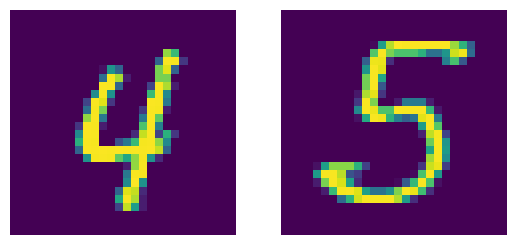

In [163]:
im1 = 3915
im2 = 5910
print(im1, im2)
im1 = standarized_test_data[im1]
im2 = standarized_test_data[im2]
mu, logvar = sarnet_vae.encode(
    torch.tensor(im1).reshape(1, 1, 28, 28).float().cuda()
)
z1 = sarnet_vae.reparameterize(mu, logvar)

mu, logvar = sarnet_vae.encode(
    torch.tensor(im2).reshape(1, 1, 28, 28).float().cuda()
)
z2 = sarnet_vae.reparameterize(mu, logvar)
plt.subplot(1,2, 1)
plt.axis("off")
plt.imshow(im1)
plt.subplot(1,2, 2)
plt.axis("off")
plt.imshow(im2)

In [164]:
generated_imgs = []
num_of_images = 400
columns = 20
rows = math.ceil(num_of_images / columns)

zs = []
ratios = np.linspace(0, 1, num_of_images)
for i in range(num_of_images):
    zs.append(z1 + (z2 - z1) * ratios[i])

np.random.seed(seed=20)
for i in tqdm(range(num_of_images)):
    img = generate_image(
        sarnet_vae,
        patch_dim,
        th=0.105,
        latent_dim=latent_dim,
        cust_z=zs[i],
        plot=False,
    )
    generated_imgs.append(img)

100%|██████████| 400/400 [00:14<00:00, 26.88it/s]


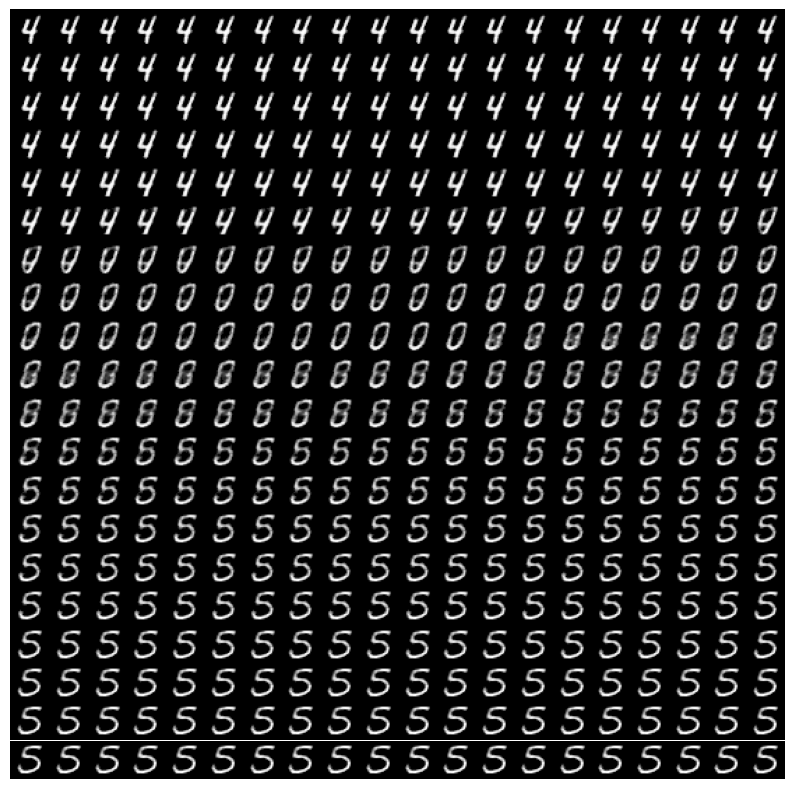

In [165]:
# Create a figure with subplots arranged in a grid
grid_size = 20
fig, axarr = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(grid_size):
    for j in range(grid_size):
        axarr[i, j].imshow(
            generated_imgs[i * grid_size + j].reshape(28, 28),
            aspect="auto",
            cmap="grey",
        )
        axarr[i, j].axis("off")  # Turn off axes for each subplot

# Display the full grid
plt.show()

1607 3234


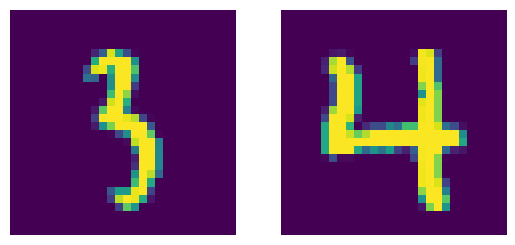

In [166]:
im1 = 1607
im2 = 3234
print(im1, im2)
im1 = standarized_test_data[im1]
im2 = standarized_test_data[im2]
mu, logvar = sarnet_vae.encode(
    torch.tensor(im1).reshape(1, 1, 28, 28).float().cuda()
)
z1 = sarnet_vae.reparameterize(mu, logvar)

mu, logvar = sarnet_vae.encode(
    torch.tensor(im2).reshape(1, 1, 28, 28).float().cuda()
)
z2 = sarnet_vae.reparameterize(mu, logvar)
plt.subplot(1,2, 1)
plt.axis("off")
plt.imshow(im1)
plt.subplot(1,2, 2)
plt.axis("off")
plt.imshow(im2)

In [169]:
generated_imgs = []
num_of_images = 400
columns = 20
rows = math.ceil(num_of_images / columns)

zs = []
ratios = np.linspace(0, 1, num_of_images)
for i in range(num_of_images):
    zs.append(z1 + (z2 - z1) * ratios[i])

np.random.seed(seed=20)
for i in tqdm(range(num_of_images)):
    img = generate_image(
        sarnet_vae,
        patch_dim,
        th = 0.105,
        latent_dim=latent_dim,
        cust_z=zs[i],
        plot=False,
    )
    generated_imgs.append(img)

100%|██████████| 400/400 [00:14<00:00, 27.07it/s]


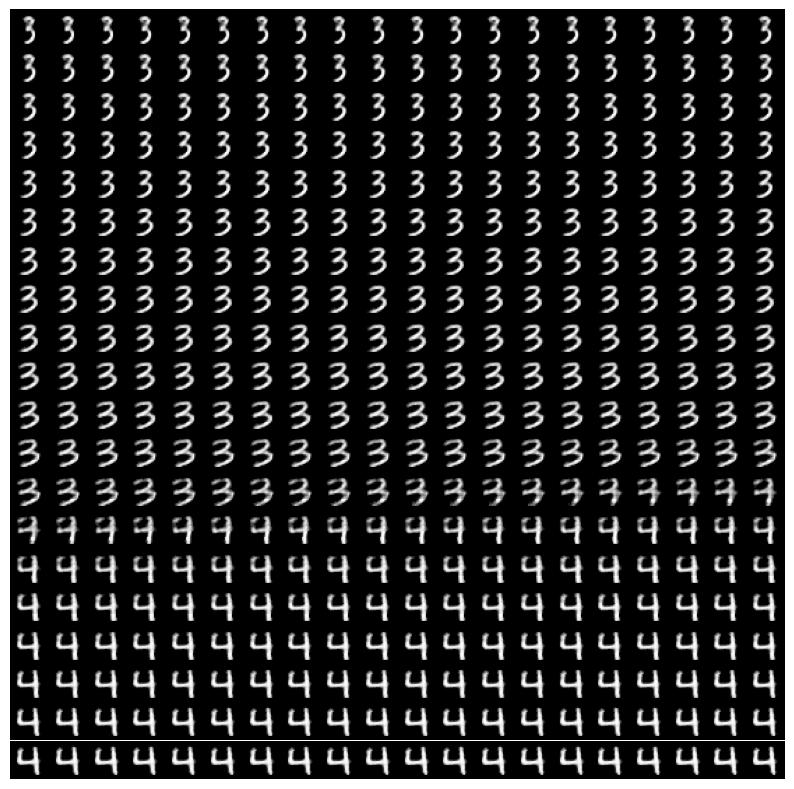

In [170]:
# Create a figure with subplots arranged in a grid
grid_size = 20
fig, axarr = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(grid_size):
    for j in range(grid_size):
        axarr[i, j].imshow(generated_imgs[i * grid_size + j].reshape(28,28), aspect="auto", cmap='grey')
        axarr[i, j].axis('off')  # Turn off axes for each subplot

# Display the full grid
plt.show()